In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np

from utils import *
from visualize import *

from maskrcnn_benchmark.data import make_data_loader

from maskrcnn_benchmark.config import cfg
from periodontitis import PerioDemo

from requests.utils import requote_uri

In [2]:
# this makes our figures bigger
# %matplotlib notebook
pylab.rcParams['figure.figsize'] = 80, 48

In [3]:
config_file = "../configs/dental/e2e_faster_rcnn_X_101_32x8d_FPN_1x_test_training_set.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
# cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

In [4]:
perio_demo = PerioDemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

In [5]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
data_loader = make_data_loader(cfg, is_train=False, is_distributed=False, start_iter=0)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
def get_image_list(data_loader, index):
    data_len = len(data_loader[index].dataset.coco.imgs)
    data_index = list(range(0, data_len))
    categories = data_loader[index].dataset.coco.loadCats(data_loader[index].dataset.coco.getCatIds())
    category_names = [category['name'] for category in categories]
    print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))
    category_ids = data_loader[index].dataset.coco.getCatIds(catNms=['square'])
    image_ids = data_loader[index].dataset.coco.getImgIds(catIds=category_ids)
    image_data = data_loader[index].dataset.coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]
    
    image_list = []

    for idx in data_index:
        original_id = data_loader[index].dataset.id_to_img_map[idx]
        image_name = '.'.join(data_loader[index].dataset.coco.imgs[original_id]['file_name'].split('.')[:-1])
        image_list.append((original_id, image_name))
        
    return image_list, category_ids

In [9]:
first_image_list, category_ids = get_image_list(data_loader, 0)
    
for img in first_image_list:
    print(img)

Custom COCO categories: 
periodontitis

(1, '118 2556.56')
(2, '127 586.55')
(3, '128 2284.58')
(4, '133 3810.58')
(5, '135 1892.58')
(6, '136 2302.58')
(7, '137 158.57')
(8, '139 2608.57')
(9, '142 2623.45')
(10, '148 3269.57')
(11, '149 1445.57')
(12, '156 3578.54')
(13, '163 3538.59')
(14, '165 1541.60')


In [ ]:
# second_image_list, category_ids = get_image_list(data_loader, 1)
    
# for img in second_image_list:
#     print(img)

In [ ]:
data_loader

In [10]:
class_names = ['BG']

for i in range(len(data_loader[0].dataset.coco.cats)):
    class_names.append(data_loader[0].dataset.coco.cats[i+1]['name'])
    
class_names

['BG', 'periodontitis']

In [11]:
# 066 1012.59 is gigival, no label
banned_list = ['066 1012.59']

In [12]:
data_loader_index = 0

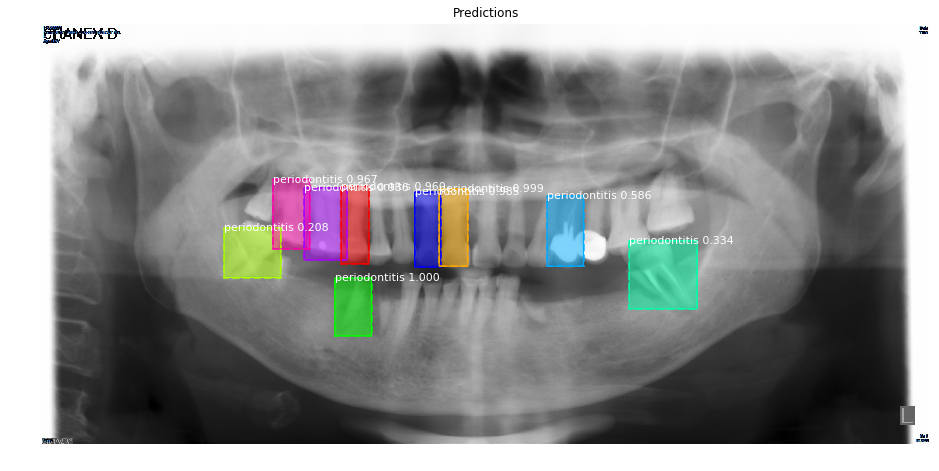

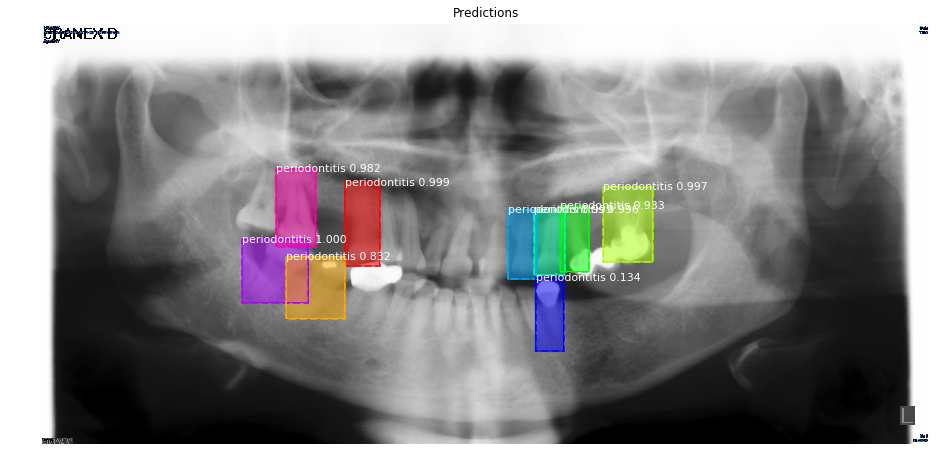

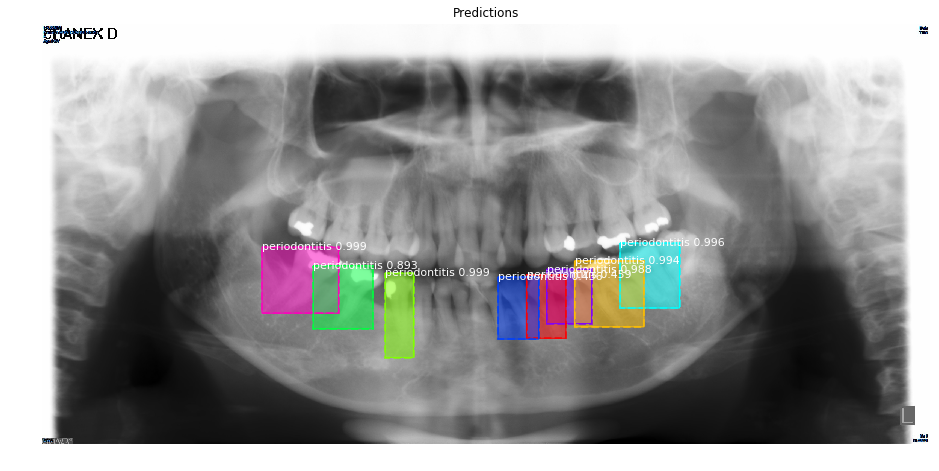

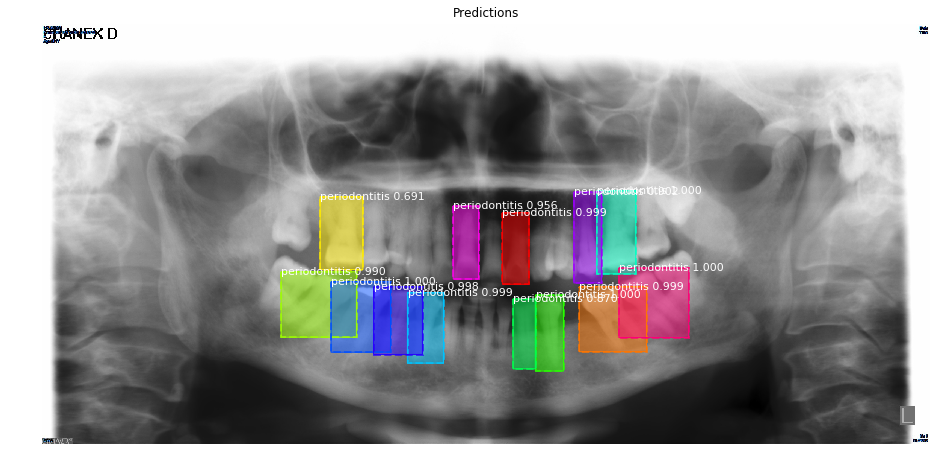

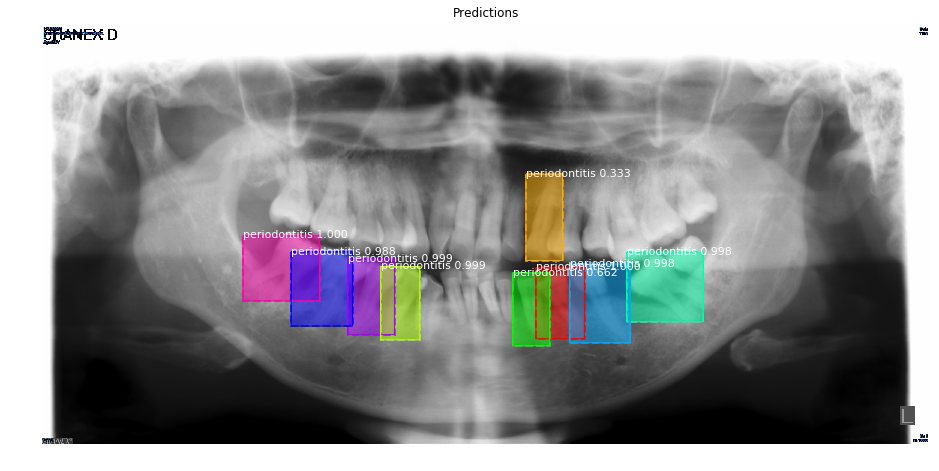

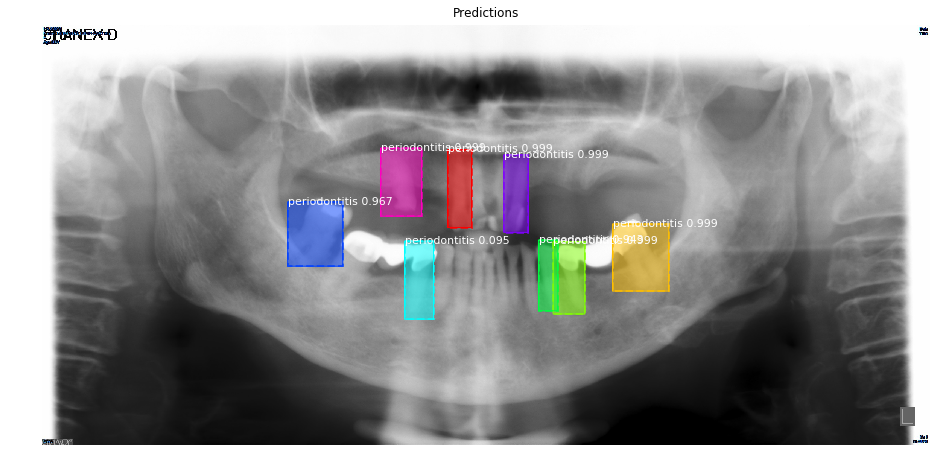

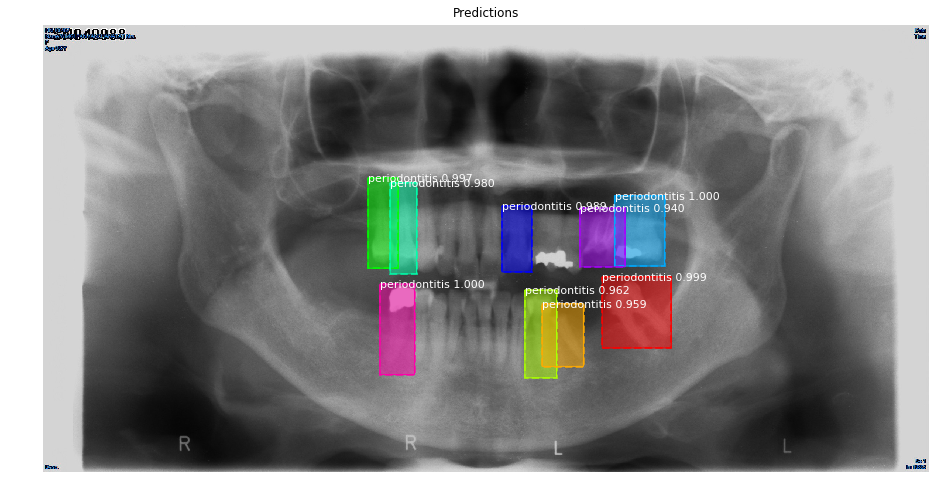

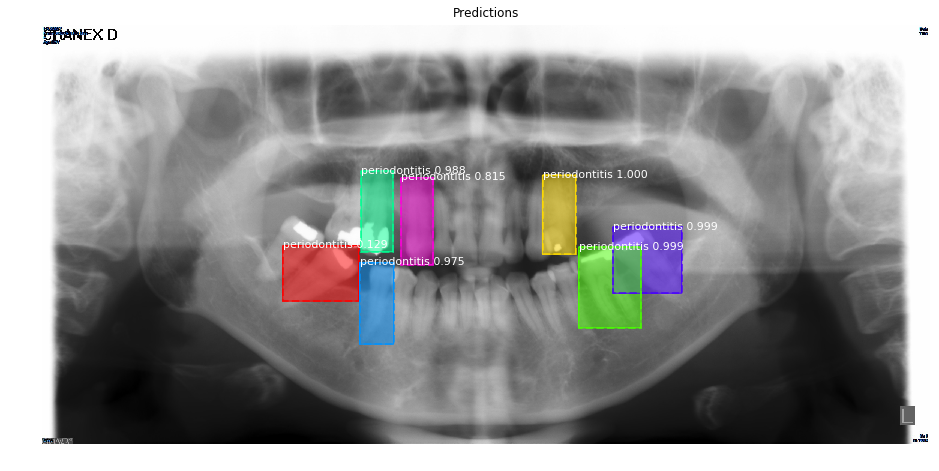

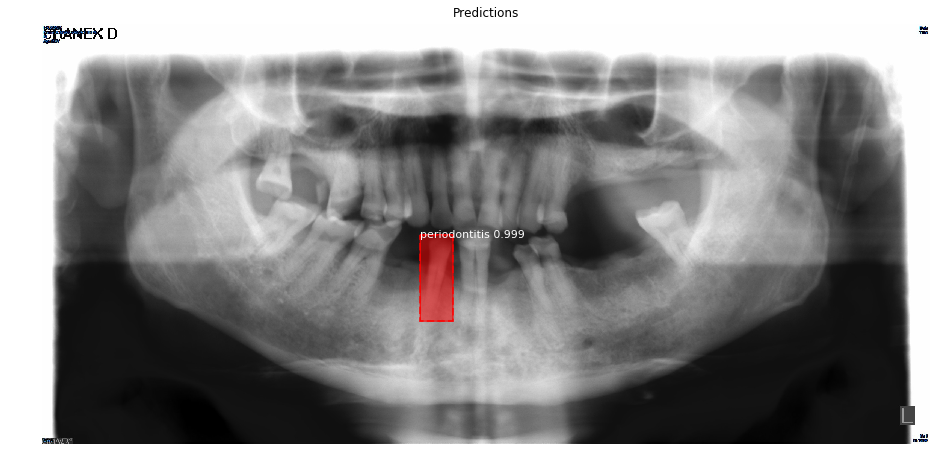

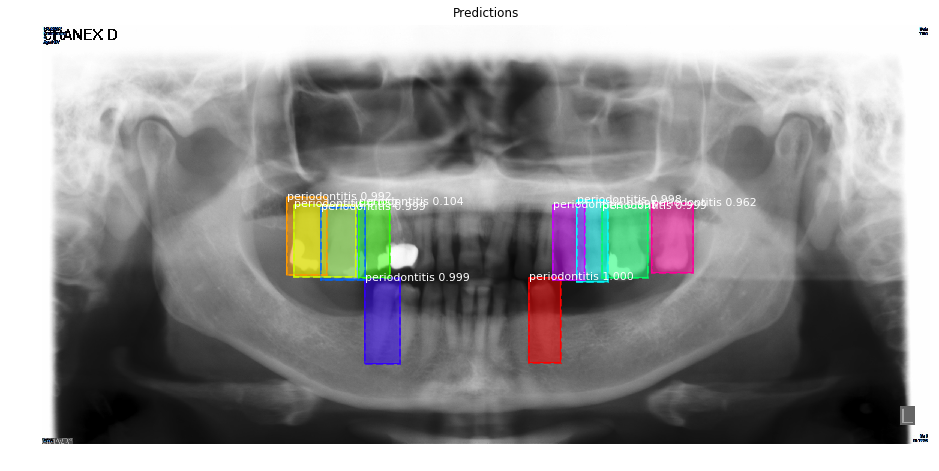

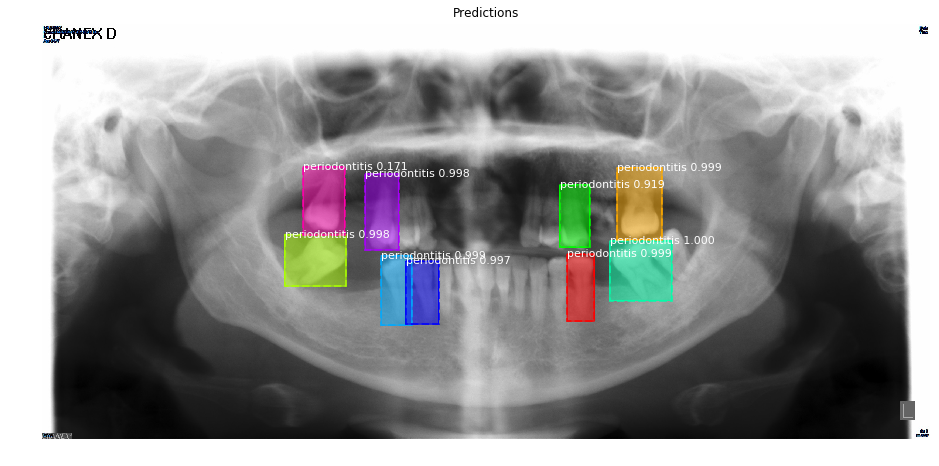

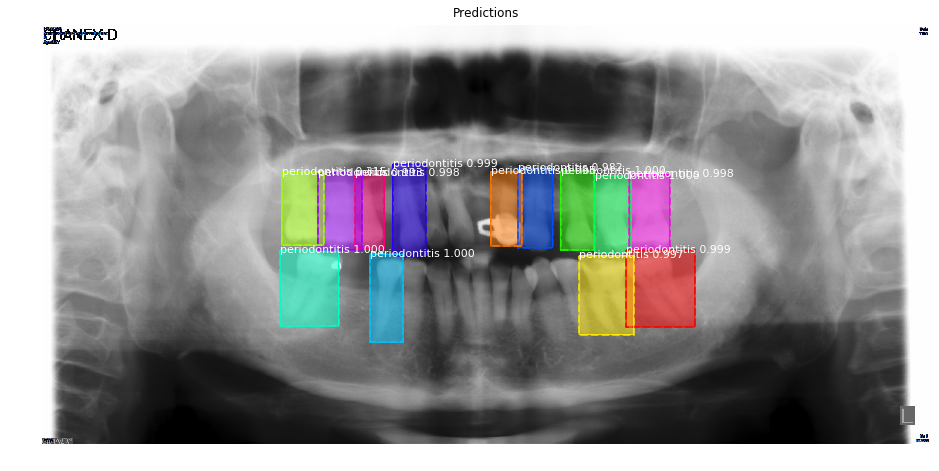

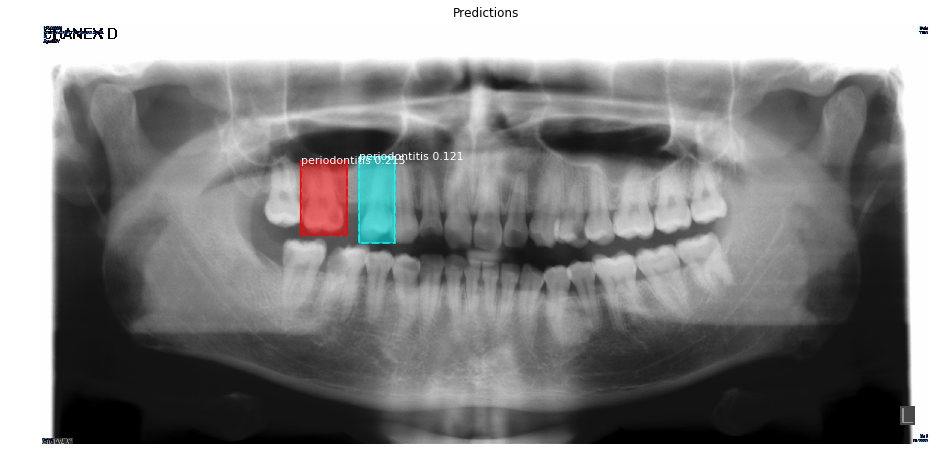

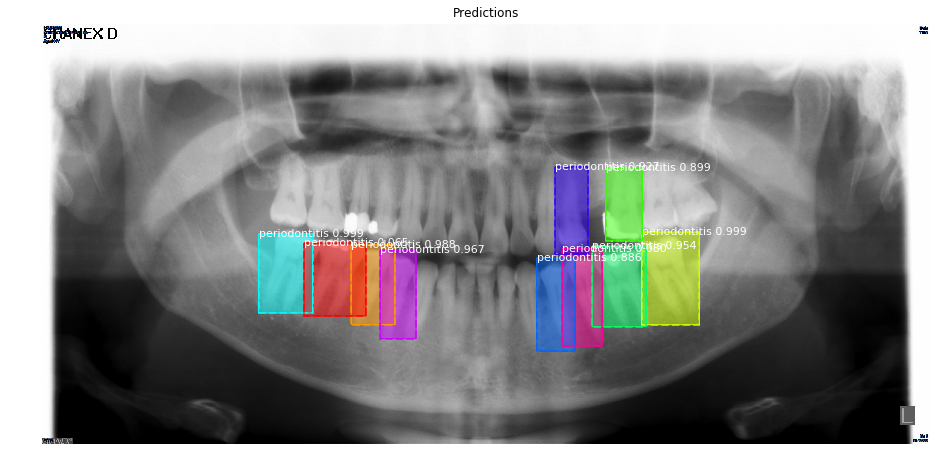

In [13]:
for deck_image in first_image_list:
    (height, width) = (
        data_loader[data_loader_index].dataset.coco.imgs[deck_image[0]]['height'],
        data_loader[data_loader_index].dataset.coco.imgs[deck_image[0]]['width']
    )
    
    annotations = data_loader[data_loader_index].dataset.coco.getAnnIds(deck_image[0], catIds=category_ids, iscrowd=None)
    number_of_annotations = len(annotations)
    
    gt_class_ids = []

    for annotation in annotations:
        class_id = data_loader[data_loader_index].dataset.coco.anns[annotation]['category_id']
        gt_class_ids.append(class_id)

    gt_class_ids = np.array(gt_class_ids).astype('int32')
        
    bboxes = []
    for annotation in annotations:
        bbox = data_loader[data_loader_index].dataset.coco.anns[annotation]['bbox']
        bboxes.append(bbox)
    
    bboxes = np.array(bboxes).astype('int32')
    
    gt_mask = np.zeros((data_loader[data_loader_index].dataset.coco.loadImgs(deck_image[0])[0]['height'], data_loader[data_loader_index].dataset.coco.loadImgs(deck_image[0])[0]['width'], len(annotations)))

    try:
        url = requote_uri("http://192.41.170.195:8000/test/{}.jpg".format(deck_image[1]))
        image = load(url)
    except:
        image = load("http://192.41.170.195:8000/val/{}.jpg".format(deck_image[1]))
    # imshow(image)    
    # compute original predictions
    predictions, raw_predictions, top_predictions, scores = perio_demo.run_on_opencv_image(image)
    # imshow(predictions)
    
    rois = np.array(top_predictions.bbox).astype('int32')
    # number_of_predicted_objects = top_predictions.get_field('mask').numpy().shape[0]
    number_of_predicted_objects = top_predictions.bbox.shape[0]
    predicted_mask = np.zeros((height, width, number_of_predicted_objects))

    
    scores = np.array(scores).astype('float32')
    class_ids = np.array(
        top_predictions.get_field("labels").tolist()
    ).astype('int32')
    
    new_rois = []
    for roi in rois:
        top_left = roi[:2]
        bottom_right = roi[2:]
        new_box = [top_left[1], top_left[0], bottom_right[1], bottom_right[0]]
        new_rois.append(new_box)
    new_rois = np.array(new_rois)

    # Create masks from bbox
    for i in zip(range(number_of_predicted_objects), new_rois):
        predicted_mask[i[1][0]:i[1][2], i[1][1]:i[1][3], i[0]] = 1
    predicted_mask = predicted_mask.astype(bool)

    new_gt_boxes = []
    for box in bboxes:
        box = box.tolist()
        top_left = box[:2]
        bottom_right = box[2:]
        new_box = [top_left[1], top_left[0], bottom_right[1], bottom_right[0]]
        new_gt_boxes.append(new_box)

    new_gt_boxes = np.array(new_gt_boxes)
    # Last 2-digit of this dataset is height and width
    new_gt_boxes[:, -2:] = new_gt_boxes[:, -2:] + new_gt_boxes[:, :-2]

        
    
    for i in zip(range(len(annotations)), new_gt_boxes):
        gt_mask[i[1][0]:i[1][2], i[1][1]:i[1][3], i[0]] = 1
    gt_mask = gt_mask.astype(bool)
    
    ax = get_ax(1)
    
    try:
        AP, precisions, recalls, overlaps = compute_ap(
            new_gt_boxes, 
            gt_class_ids, 
            gt_mask,
            new_rois, 
            class_ids, 
            scores, 
            predicted_mask
        )
        if AP >= 0.5:
            fig_name = 'folds/final_fold/testing_results/good/{}_{}.png'.format(deck_image[1], AP)
        elif AP < 0.5:
            fig_name = 'folds/final_fold/testing_results/bad/{}_{}.png'.format(deck_image[1], AP)
    except:
        fig_name = 'folds/final_fold/testing_results/noap/{}.png'.format(deck_image[1])

    if not deck_image[1] in banned_list:
        try:
            display_instances(
                image,
                new_rois,
                predicted_mask,
                class_ids,
                class_names, 
                scores,
                ax=ax,
                title="Predictions",
                save_fig=True,
                fig_name=fig_name
            )
        except ValueError as e:
            print(e)
            print(deck_image[1])
    else:
        print('Found gingival case only: {}'.format(deck_image[1]))

In [ ]:
# Gingival case
url = requote_uri("http://192.41.170.195:8000/train/066%201012.59.jpg")
# url = requote_uri('http://192.41.170.195:8000/train/086%202397.58.jpg')
image = load(url)

In [ ]:
predictions, raw_predictions, top_predictions, scores = perio_demo.run_on_opencv_image(image)

In [ ]:
imshow(predictions)